<a href="https://colab.research.google.com/github/BigBroCat/Lab/blob/Final_CW/INT411_FinalCW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import torch
import torch.optim as optim
import torch.nn as nn
from collections import deque
import gym
from gym import spaces
from gym.utils import seeding

# Design an enviroment to stimulate the ideal space
class WindyGridWorld(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 60}
# Initialize the environment and set up the state space and action space.
    def __init__(self, n_width=10, n_height=7, u_size=40, default_reward=-1, wind_strength=None):
        self.u_size = u_size
        self.n_width = n_width
        self.n_height = n_height
        self.default_reward = default_reward
        self.state = None
        self.wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.start = (0, 3)
        self.ends = [(7, 3)]
        self.reward = 0
        self.viewer = None
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(n_width * n_height)
        self.seed()

    def seed(self, seed=None): # Set a random seed for the reproducibility of the experiment.
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self): # Reset the environment to the starting state and return to it
        self.state = self._xy_to_state(*self.start)
        return self.state

    def step(self, action):
        assert self.action_space.contains(action), f"{action} is invalid"
        x, y = self._state_to_xy(self.state) # Convert state to coordinates (x, y) on the grid
        new_x, new_y = x, y
        new_y += self.wind_strength[x]  # Apply wind effect on the seed

        # Move according to action
        if action == 0: new_x -= 1  # turn left
        elif action == 1: new_x += 1  # turn right
        elif action == 2: new_y += 1  # turn up
        elif action == 3: new_y -= 1  # turn down

        # Setting limitations for x & y
        new_x = np.clip(new_x, 0, self.n_width - 1)
        new_y = np.clip(new_y, 0, self.n_height - 1)

        # Update current state and check the termination
        self.state = self._xy_to_state(new_x, new_y)
        done = (new_x, new_y) in self.ends
        reward = 1 if done else self.default_reward
        return self.state, reward, done, {}

    # Converts a one-dimensional state index to a two-dimensional coordinate
    def _state_to_xy(self, s):
        x = s % self.n_width
        y = s // self.n_width
        return x, y
    # Converts two-dimensional coordinates back to a one-dimensional state index
    def _xy_to_state(self, x, y):
        return x + y * self.n_width


# Define the DQN model
class DQN(nn.Module): # The DQN class inherits from the nn.Module class
    def __init__(self, state_space_size, action_space_size):
        super(DQN, self).__init__()
        self.embedding = nn.Embedding(state_space_size, 128)  # Integrate state indices into a 128-dimensional space
        self.net = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, action_space_size)
        )

    def forward(self, x):
        x = self.embedding(x.long())  # Ensure state indices are integers
        return self.net(x)

# Define hyperparameters

config = {
    'gamma': 0.9,
    'epsilon': 1.0,
    'epsilon_min': 0.1,
    'epsilon_decay': 0.996,
    'learning_rate': 1e-4,
    'batch_size': 128,
    'memory_size': 10000,
    'num_episodes': 600
}

# Define hyperparameters
gamma = config['gamma']
epsilon = config['epsilon']
epsilon_min = config['epsilon_min']
epsilon_decay = config['epsilon_decay']
learning_rate = config['learning_rate']
batch_size = config['batch_size']
memory = deque(maxlen=config['memory_size'])
num_episodes = config['num_episodes']


# Initialize the environment and networks, preparing to calculate
env = WindyGridWorld()
state_dim = env.observation_space.n
action_dim = env.action_space.n

dqn = DQN(state_dim, action_dim)
target_dqn = DQN(state_dim, action_dim)
target_dqn.load_state_dict(dqn.state_dict())  # Initialize target network with same weights
target_dqn.eval()  # Set the target network to evaluation mode

optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Design the policy of selecting action
def choose_action(state):
    if random.random() < epsilon:
        return env.action_space.sample()
    state = torch.tensor(state, dtype=torch.long)
    q_values = dqn(state)
    return torch.argmax(q_values).item()

# Design the training function
def train():
    if len(memory) < batch_size: # Check memory size
        return

    batch = random.sample(memory, batch_size) # Randomly sample from the memory bank
    states, actions, rewards, next_states, dones = zip(*batch) # Unzip batch data
    states = torch.tensor(states, dtype=torch.long) # Convert types of data
    actions = torch.tensor(actions, dtype=torch.int64)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.long)
    dones = torch.tensor(dones, dtype=torch.float32)

    # Get the current Q-values from main Q-network
    q_values = dqn(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

    # Get next Q-values by using the target Q-network
    next_q_values = target_dqn(next_states).max(1)[0]

    # Computing target Q-values
    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    # Computing the figure of loss
    loss = loss_fn(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


# Design the training loop
num_episodes = 600 # Setting the episodes
rewards = [] # Initializes an empty list to store the total rewards for each episode.

# Start a loop, going through each episode.
for episode in range(num_episodes):
    state = env.reset() # Setting initial states
    done = False
    total_reward = 0

    while not done:
        action = choose_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        loss = train()

    rewards.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Update the target network regularly
    if episode % 10 == 0:
        target_dqn.load_state_dict(dqn.state_dict())  # Copy weights from main Q-network to target Q-network

    print(f"Episode {episode+1}, Total Reward: {total_reward}, Loss: {loss}")

env.close()

Episode 1, Total Reward: -4883, Loss: 2.781108676686017e-13
Episode 2, Total Reward: -6428, Loss: 3.362944198670448e-06
Episode 3, Total Reward: -593, Loss: 7.0427736318379175e-06
Episode 4, Total Reward: -2099, Loss: 6.481362561316928e-06
Episode 5, Total Reward: -298, Loss: 4.320324023865396e-06
Episode 6, Total Reward: -58, Loss: 2.4386877157667186e-06
Episode 7, Total Reward: -1451, Loss: 1.724634421407245e-05
Episode 8, Total Reward: -15337, Loss: 6.526262495754054e-06
Episode 9, Total Reward: -117, Loss: 7.543946594523732e-06
Episode 10, Total Reward: -14391, Loss: 2.9903596896474482e-06
Episode 11, Total Reward: -3469, Loss: 1.313562006544089e-05
Episode 12, Total Reward: -7262, Loss: 3.647953917607083e-06
Episode 13, Total Reward: -5132, Loss: 3.0119541406747885e-05
Episode 14, Total Reward: -1210, Loss: 5.62003788218135e-06
Episode 15, Total Reward: -2346, Loss: 5.662941021000734e-06
Episode 16, Total Reward: -3600, Loss: 7.859200195525773e-06
Episode 17, Total Reward: -8013, 

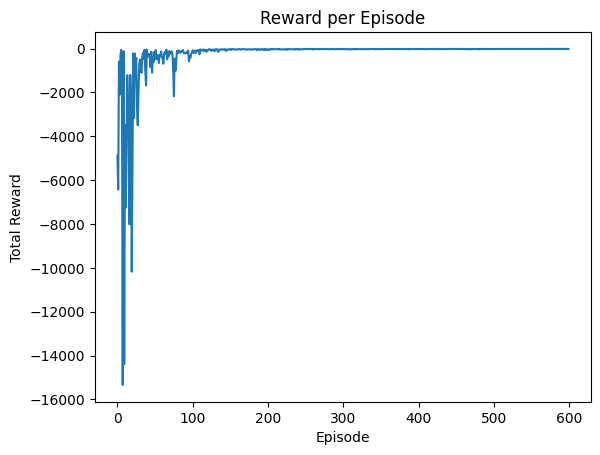

In [3]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.show()